<a href="https://colab.research.google.com/github/JulibethTinoco/covid-19/blob/master/covid19_forecastingSARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### COVID-19





Fuente de datos:
https://www.ins.gov.co/Noticias/Paginas/Coronavirus.aspx

Objetivo: identificar el mejor modelo entre SARIMAX,TBATS,LSTM Networks y NNETAR para predecir el numero de casos de coronavirus en Colombia al día siguiente y/o semana siguiente con la finalidad de que el sistema de salud estime la demanda que abrá.

In [0]:
#Importing Libraries

import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import os


from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
#from pandas.tools.plotting import autocorrelation_plot

#from pyramid.arima import auto_arima
#from pmdarima.arima import auto_arima
#import pyflux as pf
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [0]:
#!pip install tensorflow==1.14.0

In [0]:
#API connection
#!pip install requests
import requests
request = requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json')
print(request.status_code)

200


In [0]:
#200 means everything  is OK! 
request_json  = request.json()
print(request_json)

[{'id_de_caso': '1', 'fecha_de_diagn_stico': '06/03/2020', 'ciudad_de_ubicaci_n': 'Bogotá', 'departamento': 'Bogotá', 'atenci_n': 'Recuperado', 'edad': '10 a 19', 'sexo': 'F', 'tipo': 'Importado', 'pa_s_de_procedencia': 'Italia'}, {'id_de_caso': '2', 'fecha_de_diagn_stico': '09/03/2020', 'ciudad_de_ubicaci_n': 'Buga', 'departamento': 'Valle del Cauca', 'atenci_n': 'Recuperado', 'edad': '30 a 39', 'sexo': 'M', 'tipo': 'Importado', 'pa_s_de_procedencia': 'España'}, {'id_de_caso': '3', 'fecha_de_diagn_stico': '09/03/2020', 'ciudad_de_ubicaci_n': 'Medellín', 'departamento': 'Antioquia', 'atenci_n': 'Recuperado', 'edad': '50 a 59', 'sexo': 'F', 'tipo': 'Importado', 'pa_s_de_procedencia': 'España'}, {'id_de_caso': '4', 'fecha_de_diagn_stico': '11/03/2020', 'ciudad_de_ubicaci_n': 'Medellín', 'departamento': 'Antioquia', 'atenci_n': 'Recuperado', 'edad': '50 a 59', 'sexo': 'M', 'tipo': 'Relacionado', 'pa_s_de_procedencia': 'Colombia'}, {'id_de_caso': '5', 'fecha_de_diagn_stico': '11/03/2020', 

In [0]:
#Normalize the data
from pandas.io.json import json_normalize
df= pd.DataFrame.from_dict(json_normalize(request_json), orient='columns')
df.head(3)

,id_de_caso,fecha_de_diagn_stico,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,pa_s_de_procedencia
0,1,06/03/2020,Bogotá,Bogotá,Recuperado,10 a 19,F,Importado,Italia
1,2,09/03/2020,Buga,Valle del Cauca,Recuperado,30 a 39,M,Importado,España
2,3,09/03/2020,Medellín,Antioquia,Recuperado,50 a 59,F,Importado,España


In [0]:
#dim
len(df)

798

In [0]:
df.columns

Index(['id_de_caso', 'fecha_de_diagn_stico', 'ciudad_de_ubicaci_n',
       'departamento', 'atenci_n', 'edad', 'sexo', 'tipo',
       'pa_s_de_procedencia'],
      dtype='object')

In [0]:
df.columns = ['id_caso','fecha', 'ciudad_ubicacion', 'dpto','atencion', 'edad', 'sexo', 'tipo','pais_procedencia']
df.head(3)

,id_caso,fecha,ciudad_ubicacion,dpto,atencion,edad,sexo,tipo,pais_procedencia
0,1,06/03/2020,Bogotá,Bogotá,Recuperado,10 a 19,F,Importado,Italia
1,2,09/03/2020,Buga,Valle del Cauca,Recuperado,30 a 39,M,Importado,España
2,3,09/03/2020,Medellín,Antioquia,Recuperado,50 a 59,F,Importado,España


In [0]:
df.fecha=pd.to_datetime(df.fecha, format='%d/%m/%Y') 
df.set_index('fecha',inplace=True)
df.head(3) 

,id_caso,ciudad_ubicacion,dpto,atencion,edad,sexo,tipo,pais_procedencia
fecha,,,,,,,,
2020-03-06,1,Bogotá,Bogotá,Recuperado,10 a 19,F,Importado,Italia
2020-03-09,2,Buga,Valle del Cauca,Recuperado,30 a 39,M,Importado,España
2020-03-09,3,Medellín,Antioquia,Recuperado,50 a 59,F,Importado,España


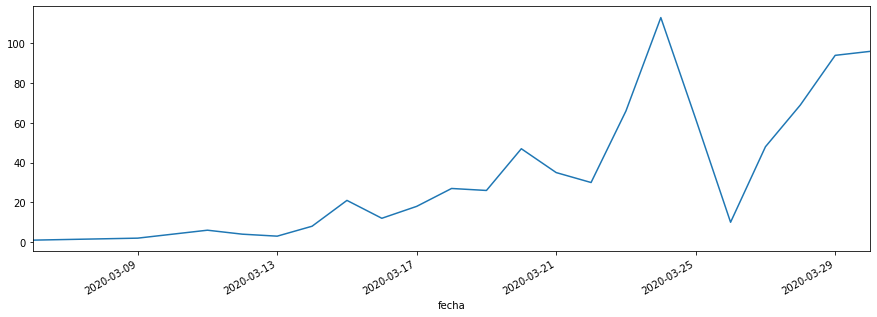

In [0]:
ts = df.groupby("fecha")["id_caso"].count()
ts.plot(figsize=(15,5))
data = pd.DataFrame(df.groupby("fecha")["id_caso"].count())

In [0]:
data.head(5)

,id_caso
fecha,
2020-03-06,1
2020-03-09,2
2020-03-11,6
2020-03-12,4
2020-03-13,3


In [0]:
data.describe()

,id_caso
count,22.000000
mean,36.272727
std,33.819101
min,1.000000
25%,8.500000
50%,26.500000
75%,58.500000
max,113.000000


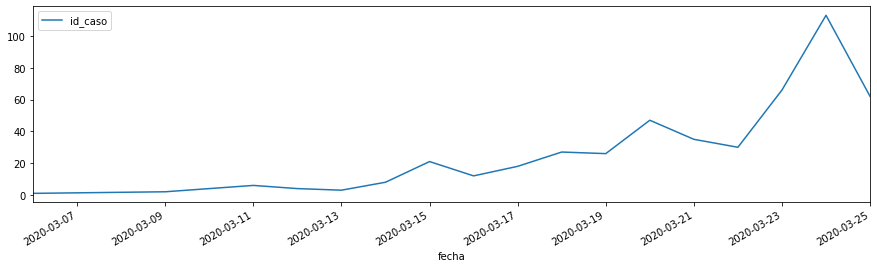

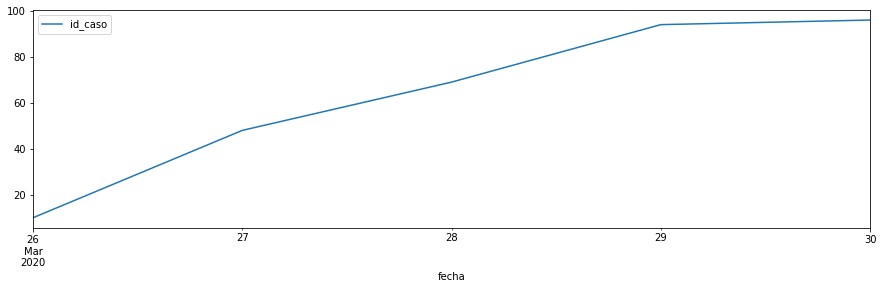

In [0]:
#split the data
test_period = int(data.shape[0]*0.8)
train = data.iloc[:test_period,].dropna()
test = data.iloc[test_period:,].dropna()
train.plot(figsize=(15,4))
test.plot(figsize=(15,4))
plt.show()

**Dickey Fuller's Test**

In [0]:
t = sm.tsa.adfuller(train.id_caso, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  3.044394
p-value                         1.000000
#Lags Used                      5.000000
Number of Observations Used    11.000000
dtype: float64

In [0]:
# function for differencing
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [0]:
t  = sm.tsa.adfuller(difference(train.id_caso,1), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                 0.045810
p-value                        0.962161
#Lags Used                     6.000000
Number of Observations Used    9.000000
dtype: float64

Por lo tanto, la serie no es estacionaria.

**Seasonal Decomposition**



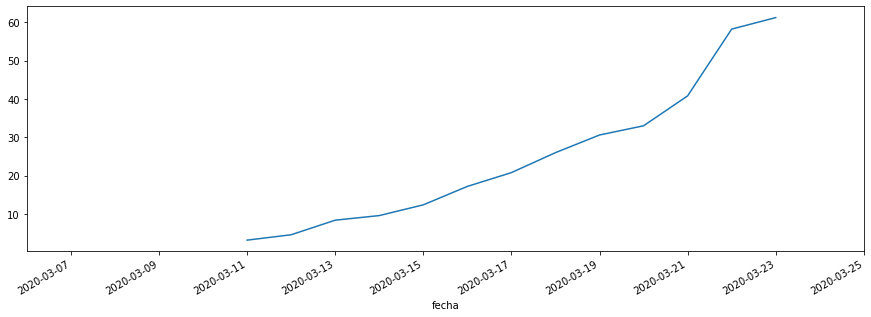

In [0]:
s = sm.tsa.seasonal_decompose(train.id_caso,freq=5)
s.trend.plot(figsize=(15,5))

**SARIMAX**


In [0]:
model = sm.tsa.statespace.SARIMAX(train['id_caso'], order=(0,1,2),trend='c')
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                id_caso   No. Observations:                   17
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 -67.771
Date:                Tue, 31 Mar 2020   AIC                            143.541
Time:                        15:28:52   BIC                            146.631
Sample:                             0   HQIC                           143.699
                                 - 17                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.6188      2.196      2.104      0.035       0.315       8.922
ma.L1         -0.5201    124.262     -0.004      0.997    -244.069     243.028
ma.L2         -0.4792     60.579     -0.008      0.994    -119.213     118.254
sigma2       241.5512   3.02e+04      0.008      0.994   -5.89e+04    5.93e+04
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                11.12
Prob(Q):                               nan   Prob(JB):                         0.00
Heteroskedasticity (H):              22.33   Skew:                             1.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

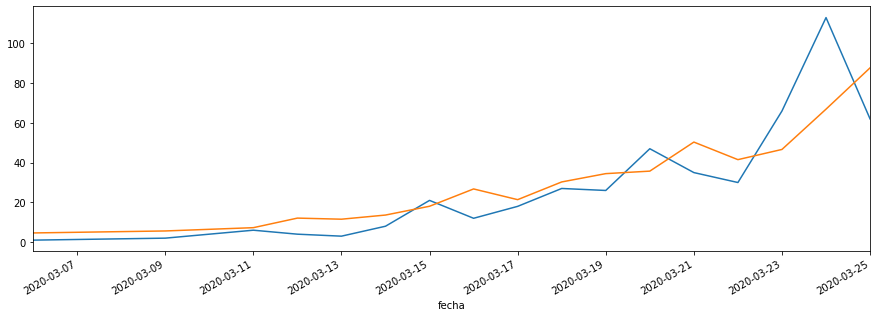

In [0]:
#model fit
train['id_caso'].plot(figsize=(15,5))
model_fit.fittedvalues.plot()
plt.show()

In [0]:
#prediction
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1)
test['predicted'] = predict.values
test.tail(5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,id_caso,predicted
fecha,,
2020-03-26,10,57.784558
2020-03-27,48,74.032776
2020-03-28,69,78.651600
2020-03-29,94,83.270424
2020-03-30,96,87.889248


In [0]:
#score
test['residual'] = abs(test['id_caso']-test['predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (abs(test['residual'])/test['id_caso']).sum()*100/len(test)
print("MAE:", MAE)
print("MAPE:", MAPE)

MAE: 20.461852426230912
MAPE: 113.18630005701797


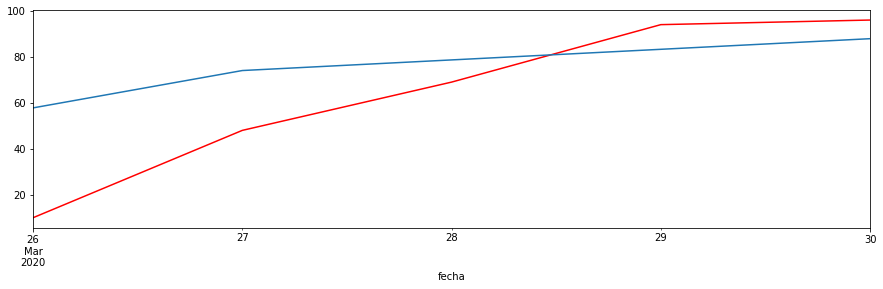

In [0]:
test['id_caso'].plot(figsize=(15,4),color = 'red')
test['predicted'].plot()
plt.show()

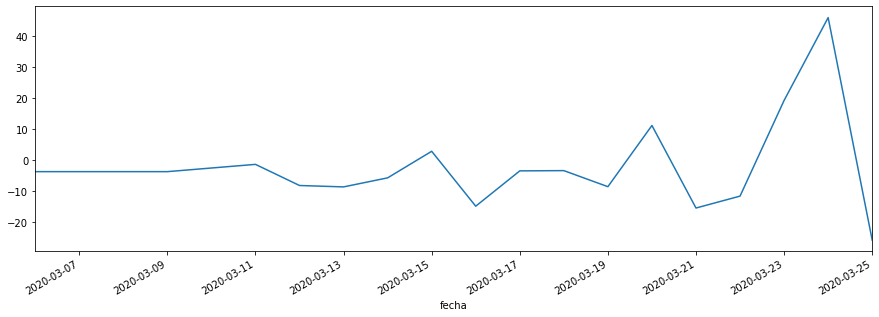

In [0]:
model_fit.resid.plot(figsize= (15,5))

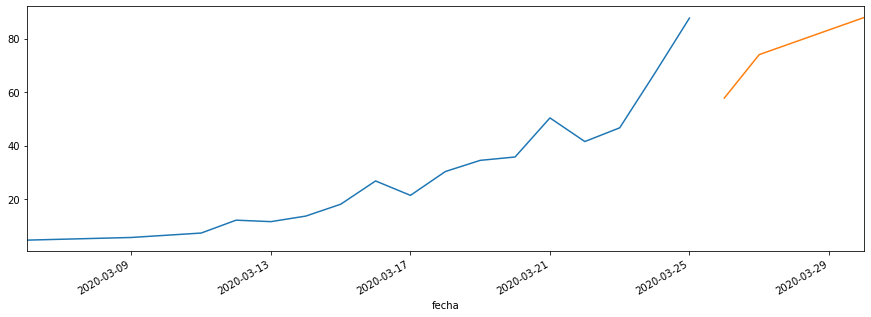

In [0]:
model_fit.fittedvalues.plot(figsize = (15,5))
test.predicted.plot()